In [ ]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
dataset_path = '/content/drive/MyDrive/Data Science/Data Science Projects/5. Final Project/3. Skin Tone Prediction /Images/Clustered'
input_shape = (90, 120, 3)
classes = ['Fair_Light', 'Medium_Tan', 'Dark_Deep']
EPOCHS = 50  # Increase the number of epochs
BS = 32


In [ ]:
data = []
labels = []

In [ ]:
for idx, class_name in enumerate(classes):
    class_path = os.path.join(dataset_path, class_name)
    for filename in os.listdir(class_path):
        image_path = os.path.join(class_path, filename)
        image = tf.keras.preprocessing.image.load_img(image_path, target_size=input_shape[:2])
        image = tf.keras.preprocessing.image.img_to_array(image)
        image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
        data.append(image)
        labels.append(idx)

FileNotFoundError: ignored

In [ ]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [ ]:
trainX, testX, trainY, testY = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=42)

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [ ]:
train_datagen = datagen.flow(trainX, trainY, batch_size=BS, shuffle=True)

In [ ]:
base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
base_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(len(classes), activation='softmax')
])

model.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
history = model.fit(
    train_datagen,
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS,
    callbacks=[lr_scheduler, early_stopping]  # Add both callbacks
)

Epoch 1/50
66/66 [==============================] - 21s 142ms/step - loss: 1.0164 - accuracy: 0.6039 - val_loss: 0.6469 - val_accuracy: 0.6648 - lr: 0.0010
Epoch 2/50
66/66 [==============================] - 6s 90ms/step - loss: 0.7231 - accuracy: 0.6557 - val_loss: 0.5966 - val_accuracy: 0.6855 - lr: 0.0010
Epoch 3/50
66/66 [==============================] - 7s 109ms/step - loss: 0.6396 - accuracy: 0.7035 - val_loss: 0.6036 - val_accuracy: 0.6987 - lr: 0.0010
Epoch 4/50
66/66 [==============================] - 8s 118ms/step - loss: 0.6231 - accuracy: 0.7208 - val_loss: 0.5433 - val_accuracy: 0.7401 - lr: 0.0010
Epoch 5/50
66/66 [==============================] - 8s 123ms/step - loss: 0.6503 - accuracy: 0.6887 - val_loss: 0.5091 - val_accuracy: 0.7815 - lr: 0.0010
Epoch 6/50
66/66 [==============================] - 6s 88ms/step - loss: 0.5985 - accuracy: 0.7313 - val_loss: 0.5298 - val_accuracy: 0.7345 - lr: 0.0010
Epoch 7/50
66/66 [==============================] - 7s 113ms/step - los

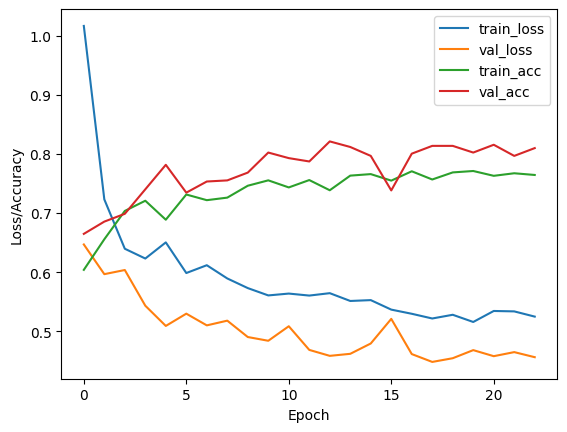

In [ ]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.show()

In [ ]:
preds = model.predict(testX)
y_pred = np.argmax(preds, axis=1)

cm = confusion_matrix(testY, y_pred)
print("Confusion Matrix:")
print(cm)

print("Classification Report:")
print(classification_report(testY, y_pred, target_names=classes))

17/17 [==============================] - 2s 50ms/step
Confusion Matrix:
[[146  49   0]
 [ 29 267   5]
 [  0  16  19]]
Classification Report:
              precision    recall  f1-score   support

  Fair_Light       0.83      0.75      0.79       195
  Medium_Tan       0.80      0.89      0.84       301
   Dark_Deep       0.79      0.54      0.64        35

    accuracy                           0.81       531
   macro avg       0.81      0.73      0.76       531
weighted avg       0.81      0.81      0.81       531



In [ ]:
model.save('/content/drive/MyDrive/Data Science/Data Science Projects/5. Final Project/3. Skin Tone Prediction /model.h5')
print("Model saved.")

Model saved.
